In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, SimpleRNN

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error

#### Defining all the Parameters needed:

In [2]:
days = 30 # The Number of Days to preddict
sequence_length = 20 # The Dataset will additionally be splitted into sequences to enhance the Prediction

######LSTM Model Parameters#######
#One note about the activation_function: tanh is GPU accelerated, relu not

activation_function = ['tanh', 'relu'] # the first one is used 2 times
optimizer_function = 'adam' # e.g. Nadam,
loss_function = 'mean_squared_error'
num_epochs = 10
batch_size = 60

######some other declerations and function###########

min_max_scalar = MinMaxScaler()

def lstm_metrics(true, predicted, model):
    print(model+"\n")
    print("Mean Absolute Error: "+str(mean_absolute_error(true, predicted)))
    print("Root Mean Square Error: "+str(np.sqrt(mean_squared_error(true, predicted))))
    print("Explained Variance Score: "+str(explained_variance_score(true, predicted)))
    print("R² Score: "+str(r2_score(true, predicted)))
    print("Max Error Scorer: "+str(max_error(true, predicted)))

#### Starting with the last Preparations

This Notebook will start with the results/cleaned dataframe from "StepA_DataPrepartion.ipynb" which is stored in under the Path "./data/daily_dataframe.csv"

In [3]:
df = pd.read_csv("./data/daily_dataframe.csv")
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,4.476415,4.478946,4.476415,4.478946,18.296675,81.131884,4.477370
1,4.765486,4.765486,4.765486,4.765486,6.520824,31.728779,4.765486
2,5.000000,5.000000,5.000000,5.000000,15.537153,77.685764,5.000000
3,5.225903,5.225903,5.225903,5.225903,7.633635,39.441143,5.225903
4,5.186993,5.227674,5.186993,5.227674,13.885945,74.060105,5.201707
...,...,...,...,...,...,...,...
3371,55192.143139,55218.473451,55167.740437,55194.338458,1.814064,100341.387345,55192.261999
3372,55834.184958,55858.268208,55811.112208,55835.612028,1.443994,80412.639688,55833.580482
3373,56911.283486,56942.541743,56881.677681,56911.995660,3.724880,213292.698642,56910.369124
3374,58346.922167,58371.047285,58323.091465,58348.516944,2.359691,137978.415411,58346.019783


Last check if there are NaN values somewhere hidden

In [4]:
df.isnull().sum(axis = 0)

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

Since the dataset has been already prepared in the first step, the are no NaN values.  
But to get a smaller dataframe I will only work with Weighted_Price, because it fully correlates with OHLC(Open,High,Low and Close) Prices

In [5]:
df = df.drop(['Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)'], axis = 1)
df

,Weighted_Price
0,4.477370
1,4.765486
2,5.000000
3,5.225903
4,5.201707
...,...
3371,55192.261999
3372,55833.580482
3373,56910.369124
3374,58346.019783


#### Splitting the data in test and train

In [6]:
#two empty arrays for X and Y and a scaled version of the current Dataframe

setX = []
setY = []

#Creating a Scaled Dataframe
df_scaled = min_max_scalar.fit_transform(df)

In [7]:
#Populating the the numpy Arrays setX and setY with the values

setX = np.array([df_scaled[x-sequence_length:x] for x in range(sequence_length, len(df_scaled))])
setY = np.array([df_scaled[x] for x in range(sequence_length, len(df_scaled))])

#Reshape both Arrays
setX.reshape(-1, 1)
setY.reshape(-1, 1)

array([[4.04374638e-05],
       [3.57595939e-05],
       [3.76825727e-05],
       ...,
       [9.41325389e-01],
       [9.65073567e-01],
       [9.71993472e-01]])

In [8]:
# Creating train, test true and test
#Slicing into train (all values except the last x days(Parameter from the beginning))
train = setX[:-days]
true_train = setY[:-days]

#Slicing into test (only the last x days(Parameter from beginning))
test = setX[len(setX)-days:]
true_test = setY[len(setY)-days:]

In [9]:
regressor = Sequential()
regressor.add(SimpleRNN(units = 20,activation=activation_function[0], return_sequences = True, input_shape = (sequence_length, 1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 20,activation=activation_function[1], return_sequences = True))
regressor.add(SimpleRNN(units = 1,activation=activation_function[0], return_sequences = True))
#regressor.add(SimpleRNN(units = 10, activation=activation_function[1], return_sequences = True))
regressor.add(SimpleRNN(units = 20))        
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

2022-01-16 11:37:24.675552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7


In [10]:
#Compiling the Model
regressor.compile(optimizer = optimizer_function, loss = loss_function)
#Fitting and saving the history for later
history=regressor.fit(train, true_train, epochs = num_epochs, batch_size = batch_size)

Epoch 1/10
56/56 [==============================] - 9s 99ms/step - loss: 0.0332
Epoch 2/10
56/56 [==============================] - 6s 100ms/step - loss: 0.0049
Epoch 3/10
56/56 [==============================] - 6s 99ms/step - loss: 0.0041
Epoch 4/10
56/56 [==============================] - 5s 97ms/step - loss: 0.0035
Epoch 5/10
56/56 [==============================] - 6s 99ms/step - loss: 0.0030
Epoch 6/10
56/56 [==============================] - 6s 100ms/step - loss: 0.0022
Epoch 7/10
56/56 [==============================] - 5s 97ms/step - loss: 0.0021
Epoch 8/10
56/56 [==============================] - 5s 97ms/step - loss: 0.0018
Epoch 9/10
56/56 [==============================] - 5s 95ms/step - loss: 0.0014
Epoch 10/10
56/56 [==============================] - 5s 91ms/step - loss: 0.0016


In [11]:
#Prediction of the test and train prices
predicted_prices_train = regressor.predict(train)
predicted_prices_test = regressor.predict(test)  

In [12]:
#Scaling of the predicted Prices
predicted_prices_train = min_max_scalar.inverse_transform(predicted_prices_train)
predicted_prices_test = min_max_scalar.inverse_transform(predicted_prices_test)

#Scaling of the "true" prices
true_train = min_max_scalar.inverse_transform(true_train)
true_test = min_max_scalar.inverse_transform(true_test)

#### Evaluation of the Metrics:

I decided to use the following the metrics to evaluate the Model:
  
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- Explained Variance Score (EVS)
- R² Score (R2)
- Max Error Score (MES)

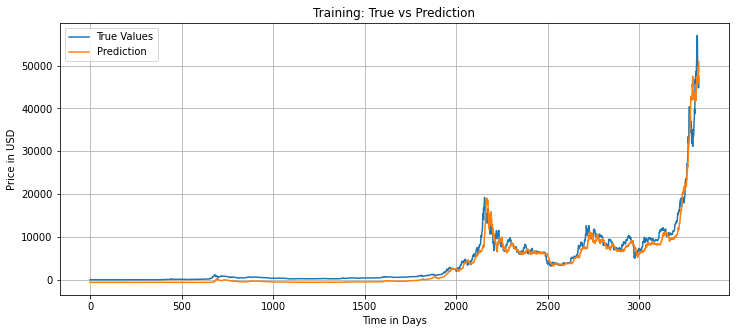

In [13]:
# First Plotting the Training Period with Prediction vs True Values

plt.figure(figsize=(12, 5))
plt.title("Training: True vs Prediction")
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.grid(visible=True, which='major', axis='both')
plt.plot(true_train, label = 'True Values')
plt.plot(predicted_prices_train, label = 'Prediction')
plt.legend()
plt.show()

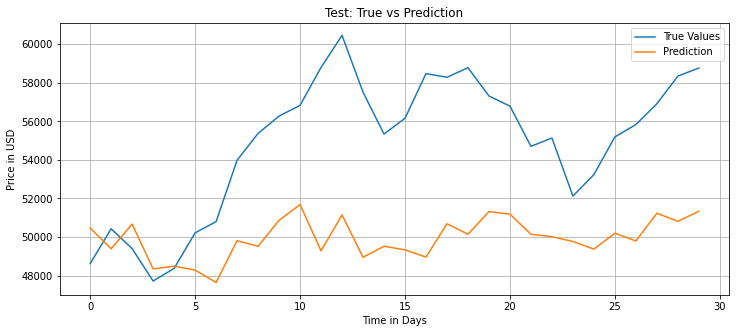

In [14]:
#Now plotting the Test Period: Prediction vs. True Values
plt.figure(figsize=(12, 5))
plt.title("Test: True vs Prediction")
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.grid(visible=True, which='major', axis='both')
plt.plot(true_test, label = 'True Values')
plt.plot(predicted_prices_test, label = 'Prediction')
plt.legend()
plt.show()

In [15]:
# Printing the metrics mentioned above
lstm_metrics(true_train, predicted_prices_train, "Training Period:")
print("\n")
print("********************************************************\n")
lstm_metrics(true_test, predicted_prices_test, "Test Period:")

Training Period:

Mean Absolute Error: 1020.4767730127392
Root Mean Square Error: 1506.8895516622144
Explained Variance Score: 0.9615141525402062
R² Score: 0.9496919630385792
Max Error Scorer: 16315.50641732847


********************************************************

Test Period:

Mean Absolute Error: 5183.316649344028
Root Mean Square Error: 5835.3451747764
Explained Variance Score: 0.21673518808182568
R² Score: -1.723926862465225
Max Error Scorer: 9511.556017656942


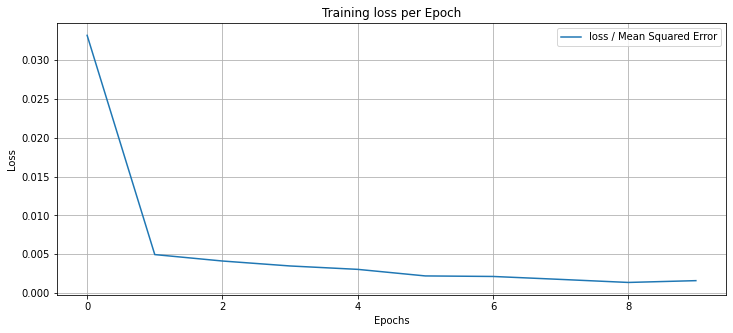

In [16]:
#Mean Squared Error/ Epoch
plt.figure(figsize=(12, 5))
plt.title("Training loss per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(visible=True, which='major', axis='both')
plt.plot(history.history['loss'], label="loss / Mean Squared Error")
plt.legend()
plt.show()